In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../daaad/')

from daaad.src.learning_model.models.cvae import CondVAEModel
from daaad.src.learning_model.dataset.data_set import DataSet
from src import data_io, cvae_utils
import numpy as np

np.random.seed(42)
num_modes = 2
model_name = 'spiral'
try:
    model = CondVAEModel.load_model(f'../saved_models/{model_name}_{num_modes}modes/')
except:
    cvae_utils.train_cvae(num_modes=num_modes, data_fraction=1, only_freqs=False, model_name=model_name, batch_size=128, val_split=.1)
    os.mkdir(f'../saved_models/{model_name}_{num_modes}modes/test_data/')
    model = CondVAEModel.load_model(f'../saved_models/{model_name}_{num_modes}modes/')

dataset, _ = data_io.get_spiral_data(num_modes=num_modes)
np.random.seed(42)
train_gen, val_gen, test_gen = dataset.get_data_loaders(128, val_split=.1, test_split=.1)


/home/christian/miniconda3/envs/renku_spiral_design/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/christian/miniconda3/envs/renku_spiral_design/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/christian/miniconda3/envs/renku_spiral_design/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/christian/miniconda3/envs/renku_spiral_design/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/christian/miniconda3/envs/renku_spiral_design/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divi

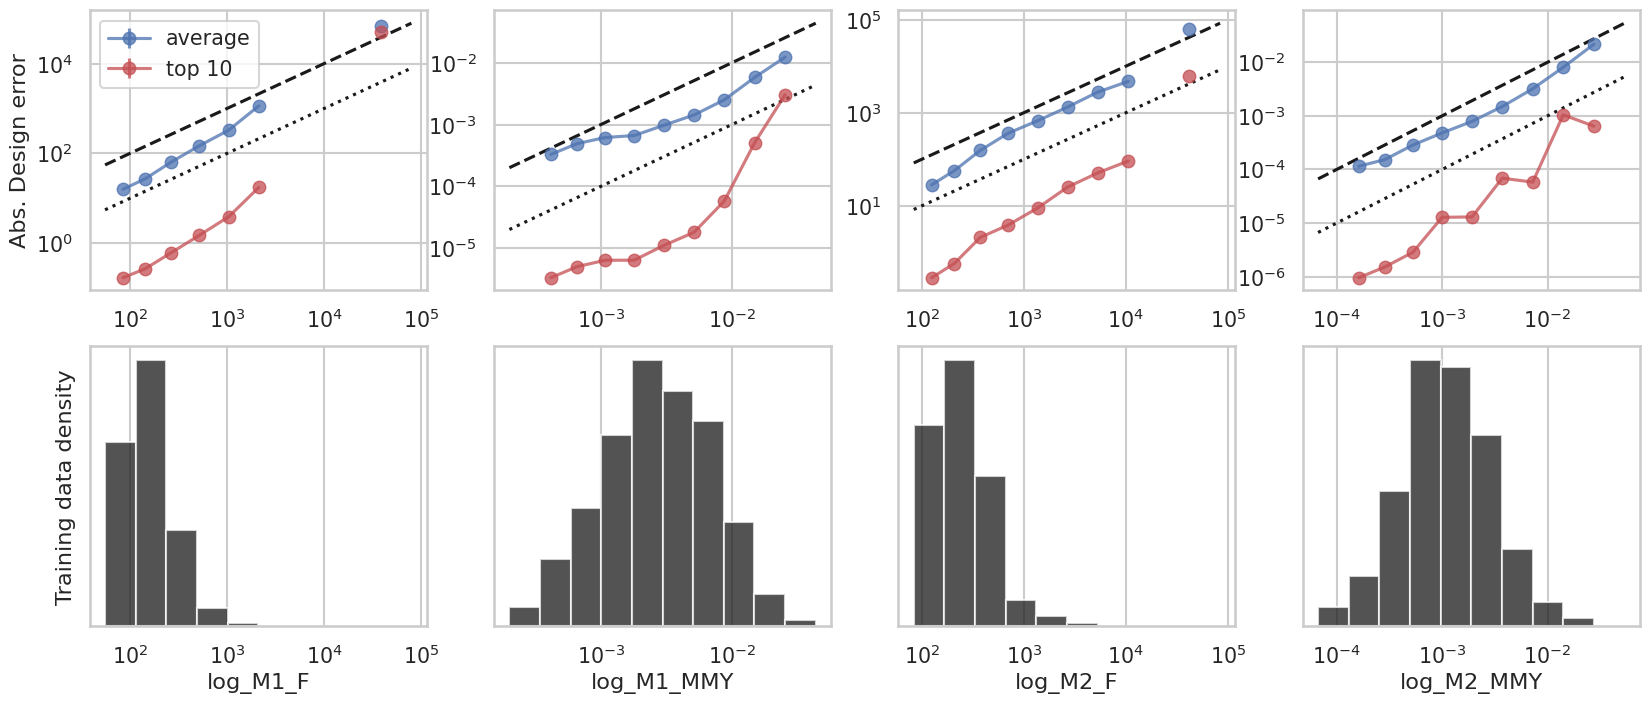

In [2]:
fig, ax1_list, ax2_list = cvae_utils.plot_design_errors(model=model, data_gen=test_gen, linear=True, correction_factors={'modal_mass': 1,'freqs': 1}) 

In [26]:

from daaad.src.utils import rec_concat_dict
from torch.utils.data import DataLoader
import torch
data_gen = test_gen

if isinstance(data_gen, DataLoader):
    data = rec_concat_dict([batch for batch in data_gen])
    num_designs = len(data_gen.dataset.indices)
else:
    data = data_gen
    num_designs = len(data.items()[0].shape[0])

In [27]:
pred_samples = {}
num_samples = 1000
for isample in range(num_samples):
    pred = {}
    with torch.no_grad():
        pred['x'] = model.decode(data=data)
        pred.update(model.encode(pred['x']))
    pred_samples[isample] = pred

In [31]:
pred = {'x': {}, 'y': {}}
for key in pred_samples[0]['x']:
    pred['x'][key] = np.concatenate([pred_samples[isample]['x'][key][:,:,None] for isample in range(num_samples)], axis=2)
for key in pred_samples[0]['y']:
    pred['y'][key] = np.concatenate([pred_samples[isample]['y'][key][:,:,None] for isample in range(num_samples)], axis=2)

In [32]:
pred['x']['spiral_height'].shape

(1043, 1, 1000)